In [1]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [2]:
import os
import pandas as pd

benign_dirs = [
    r'/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases'
]

Malignant_dir = [ r'/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases']

Normal_dirs = [
    r'/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases'
]

filepaths = []
labels = []
dict_lists = [benign_dirs, Malignant_dir, Normal_dirs]
class_labels = ['benign', 'Malignant', 'Normal']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Lung_data = pd.concat([Fseries, Lseries], axis=1)
Lung_df = pd.DataFrame(Lung_data)
print(Lung_df.head())
print(Lung_df["labels"].value_counts())

                                           filepaths  labels
0  /kaggle/input/the-iqothnccd-lung-cancer-datase...  benign
1  /kaggle/input/the-iqothnccd-lung-cancer-datase...  benign
2  /kaggle/input/the-iqothnccd-lung-cancer-datase...  benign
3  /kaggle/input/the-iqothnccd-lung-cancer-datase...  benign
4  /kaggle/input/the-iqothnccd-lung-cancer-datase...  benign
labels
Malignant    561
Normal       416
benign       120
Name: count, dtype: int64


In [3]:
Lung_df.shape

(1097, 2)

In [4]:
train_images, test_images = train_test_split(Lung_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Lung_df, test_size=0.2, random_state=42)

In [5]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(877, 2)
(330, 2)
(220, 2)
(767, 2)


In [6]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(224,224),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 877 validated image filenames belonging to 3 classes.
Found 330 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [7]:
classes=list(train.class_indices.keys())
print (classes)

['Malignant', 'Normal', 'benign']


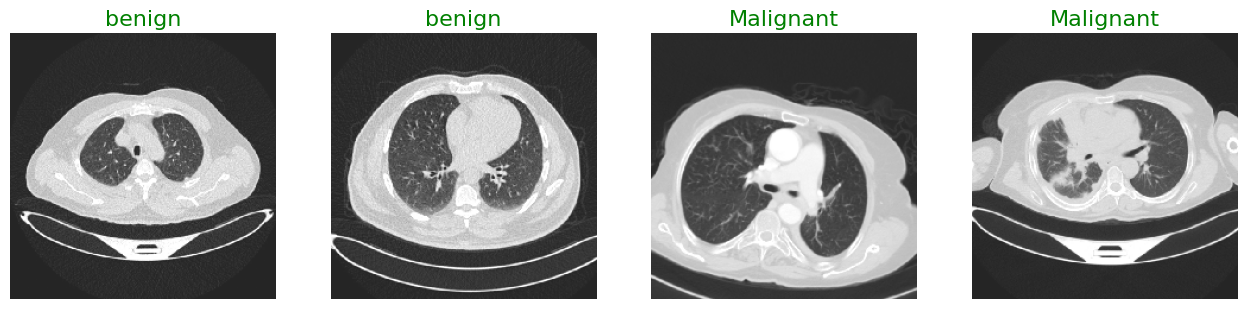

In [8]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [9]:
import keras
import tensorflow as tf
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 73, 73, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                        

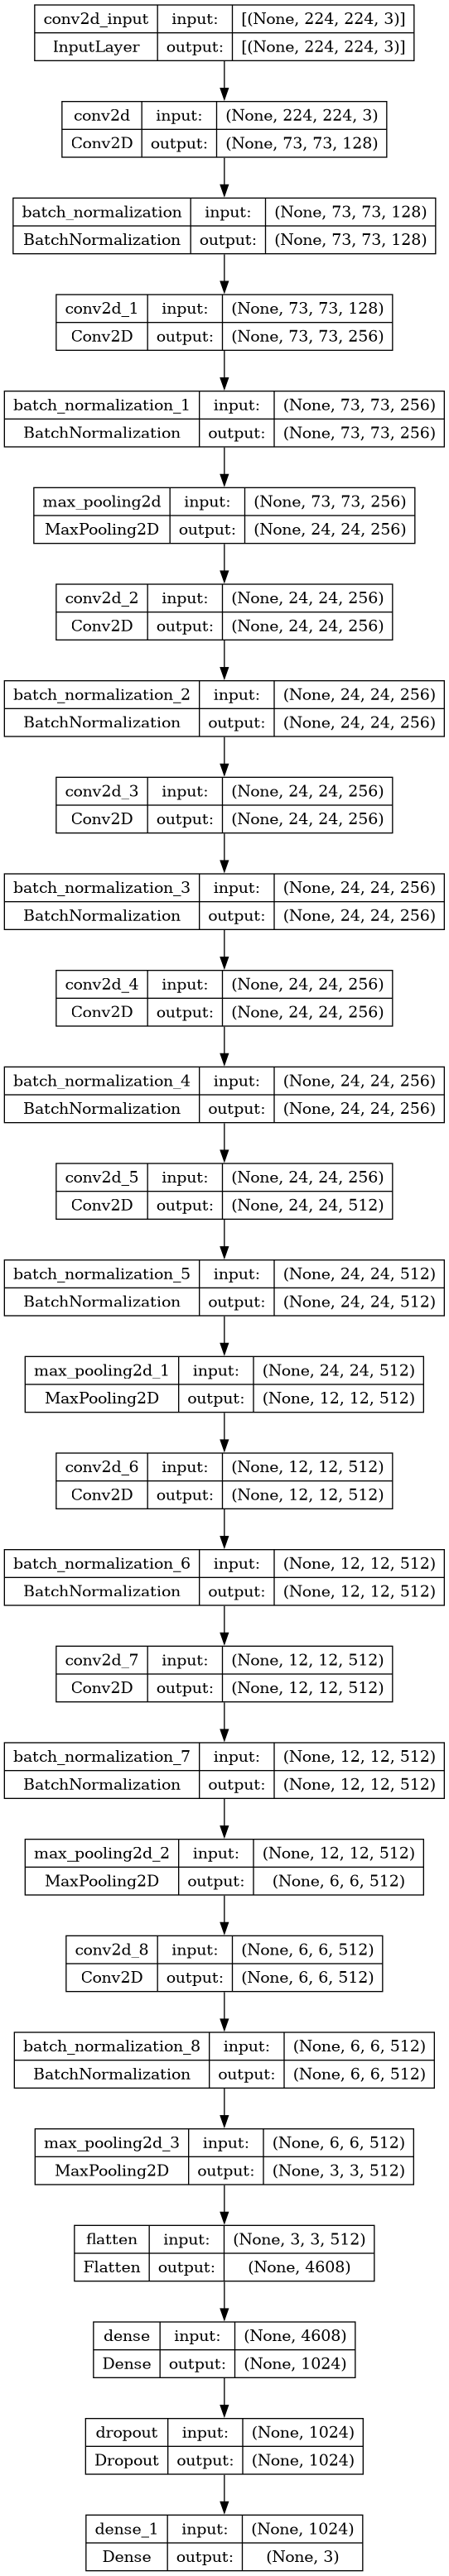

In [10]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    'best_model.h5',   
    monitor='val_loss',  
    save_best_only=True,
    mode='min',          
    verbose=1            
)

history = model.fit(
    train,
    epochs=10,
    validation_data=val,
    verbose=1,
    callbacks=[checkpoint_callback] 
)

Epoch 1/10
220/220 [==============================] - ETA: 0s - loss: 1.4554 - accuracy: 0.6762
Epoch 1: val_loss improved from inf to 1.09580, saving model to best_model.h5
220/220 [==============================] - 333s 2s/step - loss: 1.4554 - accuracy: 0.6762 - val_loss: 1.0958 - val_accuracy: 0.4773
Epoch 2/10
220/220 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.8700
Epoch 2: val_loss improved from 1.09580 to 0.17817, saving model to best_model.h5
220/220 [==============================] - 331s 2s/step - loss: 0.3905 - accuracy: 0.8700 - val_loss: 0.1782 - val_accuracy: 0.9636
Epoch 3/10
220/220 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9567
Epoch 3: val_loss improved from 0.17817 to 0.12469, saving model to best_model.h5
220/220 [==============================] - 334s 2s/step - loss: 0.0955 - accuracy: 0.9567 - val_loss: 0.1247 - val_accuracy: 0.9591
Epoch 4/10
220/220 [==============================] - ETA: 0s - loss: 0.07

In [20]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('best_model.h5')
model.evaluate(test, verbose=1)

83/83 [==============================] - 32s 378ms/step - loss: 0.0334 - accuracy: 0.9939


[0.03344966843724251, 0.9939393997192383]

In [21]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) 

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

83/83 [==============================] - 32s 377ms/step


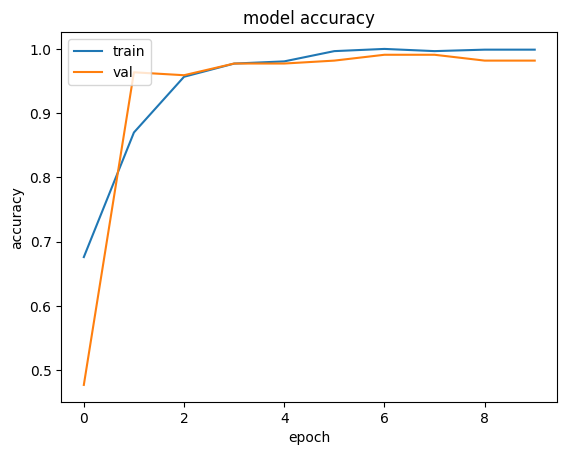

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

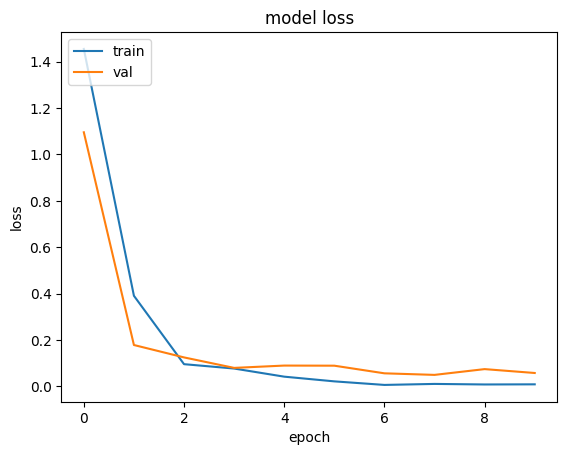

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

   Malignant       0.99      1.00      1.00       174
      Normal       0.99      0.99      0.99       116
      benign       1.00      0.97      0.99        40

    accuracy                           0.99       330
   macro avg       1.00      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330

Accuracy of the Model: 99.4%


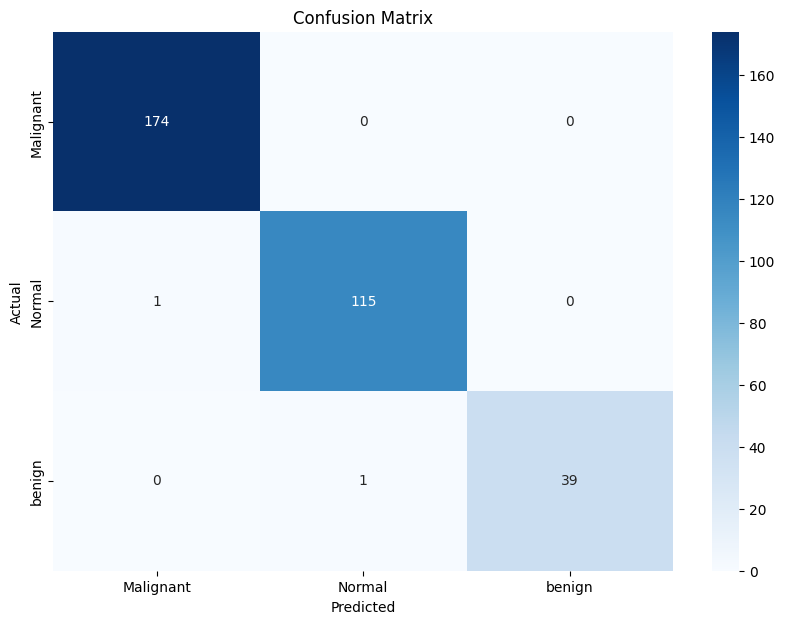

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Malignant', 'Normal', 'benign']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [26]:
from tensorflow.keras.models import Model

model = tf.keras.models.load_model('/kaggle/input/lung_model/keras/default/1/Lung_Model.keras')

last_conv_layer = model.get_layer('conv2d_8')  

model_with_activations = Model(inputs=model.input,
                               outputs=[last_conv_layer.output, model.output])

model_with_activations.save('modified_model_with_activations.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model_with_activations)
tflite_model = converter.convert()

# Save the .tflite model
with open('model_with_activations.tflite', 'wb') as f:
    f.write(tflite_model)

1/1 [==============================] - 0s 344ms/step


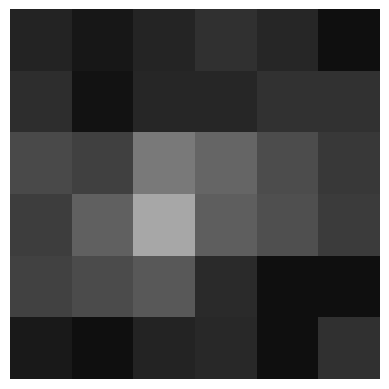

In [27]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to preprocess the input image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize if your model expects it
    return img_array

def compute_gradcam(model, img_array, layer_name):
    # Get the predictions for the input image
    preds = model.predict(img_array)
    class_idx = np.argmax(preds[0])  # Get the class index of the predicted class

    # Get the gradient model
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Calculate the gradient of the predicted class wrt to the chosen conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]  # Class-specific loss

    grads = tape.gradient(loss, conv_outputs)  # Gradients wrt to conv layer output
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

    # Convert tensors to NumPy arrays for element-wise operations
    conv_outputs = conv_outputs.numpy()[0]  # Convert conv_outputs to NumPy array
    pooled_grads = pooled_grads.numpy()     # Convert pooled_grads to NumPy array

    # Multiply the pooled gradients with the convolution outputs
    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Compute the heatmap
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU to keep only positive influence
    heatmap /= np.max(heatmap)  # Normalize to [0, 1]
    
    return heatmap

def overlay_heatmap(heatmap, img_path, alpha=0.6):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)  # Rescale heatmap to [0, 255]
    heatmap = np.stack([heatmap] * 3, axis=-1)  # Make it 3-channel for RGB
    heatmap = np.array(heatmap)

    # Overlay heatmap on original image
    plt.imshow(img / 255.0)
    plt.imshow(heatmap, cmap='viridis', alpha=alpha)
    plt.axis('off')
    plt.show()

img_path = '/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (1).jpg'
img_array = preprocess_image(img_path)

heatmap = compute_gradcam(model, img_array, layer_name="conv2d_8")

overlay_heatmap(heatmap, img_path)


1/1 [==============================] - 0s 118ms/step


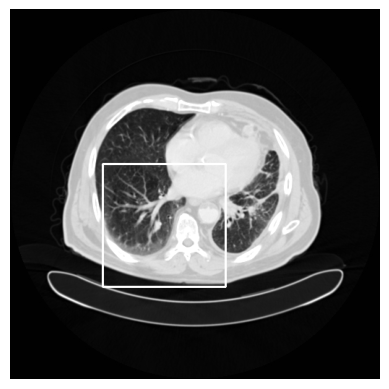

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def draw_bounding_box_on_heatmap(heatmap, img_path, threshold=0.5, top_percentage=0.2):
    # Load the original grayscale image
    img = image.load_img(img_path, color_mode="grayscale")
    img = image.img_to_array(img)
    img_height, img_width = img.shape[0], img.shape[1]  
    # Apply a threshold to the heatmap
    heatmap = np.uint8(255 * heatmap)

    # Keep only the top N% of the heatmap values
    top_n_percent_value = np.percentile(heatmap, (1 - top_percentage) * 100)
    heatmap[heatmap <= top_n_percent_value] = 0

    # Resize the heatmap to match the original image size
    thresholded_heatmap = cv2.resize(heatmap, (img_width, img_height))

    # Find the contours in the thresholded heatmap
    contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area to find the largest one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    if len(contours) > 0:
        # Draw bounding box around the largest contour
        x, y, w, h = cv2.boundingRect(contours[0])
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Draw a red bounding box

    # Plot the image with the bounding box
    plt.imshow(img.squeeze(), cmap='gray')  # Grayscale images need 'gray' cmap
    plt.axis('off')
    plt.show()

# Example usage
img_path = '/kaggle/input/the-iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (1).jpg'
img_array = preprocess_image(img_path)  # Ensure you preprocess the image correctly

# Compute the heatmap for the 'conv2d_8' layer
heatmap = compute_gradcam(model, img_array, layer_name="conv2d_8")

draw_bounding_box_on_heatmap(heatmap, img_path, threshold=0.9, top_percentage=0.02)
